# Variational Autoencoder for Electrical Load Time Series Generation

In [2]:
import os, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.loggers import WandbLogger
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from special_loss_fn import DilateLoss

import wandb
wandb.login()


True

In [4]:
class AutoencoderDataset(Dataset):
    def __init__(self, data_dir, split, train_ratio, val_ratio, test_ratio):


        load_table = self._load_data(data_dir)

        indices = torch.randperm(load_table.shape[0])

        train_indices = indices[:int(load_table.shape[0] * train_ratio)]
        val_indices = indices[int(load_table.shape[0] * train_ratio):int(load_table.shape[0] * (train_ratio + val_ratio))]
        test_indices = indices[int(load_table.shape[0] * (train_ratio + val_ratio)):]

        if split == 'train':
            self.load_table = load_table[train_indices]
        elif split == 'val':
            self.load_table = load_table[val_indices]
        elif split == 'test':
            self.load_table = load_table[test_indices]

    def __len__(self):
        return self.load_table.shape[0]


    def __getitem__(self, idx):
        input_chunk = self.load_table[idx,:]
        return input_chunk
        
    def _load_data(self, data_dir):
        df = pd.read_csv(os.path.join(data_dir, 'household_data_not_augmented.csv'), index_col=0, parse_dates=True)
        return df.values


class ElectricalLoadDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super(ElectricalLoadDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self.collate_fn_

    def collate_fn_(self, batch):
        input_chunks = zip(*batch)
        input_chunks= np.stack(input_chunks, axis=1)
        input_tensor = torch.FloatTensor(input_chunks)
        return input_tensor
    

In [5]:
train_dataset = AutoencoderDataset(data_dir='../data', split='train', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
val_dataset = AutoencoderDataset(data_dir='../data', split='val', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
test_dataset = AutoencoderDataset(data_dir='../data', split='test', train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

train_dataloader = ElectricalLoadDataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = ElectricalLoadDataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = ElectricalLoadDataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
train_dataloader

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\torch\utils\data\dataloader.py:671: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = self._dataset_fetcher.fetch(index)  # may raise StopIteration


torch.Size([32, 24])


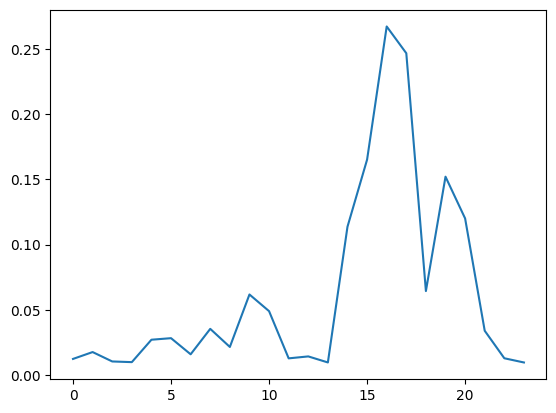

In [7]:
for i , x in enumerate(train_dataloader):
    print(x.shape)
    pd.Series(x[9,:]).plot()
    break


In [8]:
class VAE(LightningModule):

    def __init__(self, input_dim, hidden_dim = 200, z_dim = 20):
        super().__init__()

        #encoder
        self.series2hid = nn.Linear(input_dim, hidden_dim)
        self.hid2mean = nn.Linear(hidden_dim, z_dim)
        self.hid2sigma = nn.Linear(hidden_dim, z_dim)
        #decoder
        self.z2hid = nn.Linear(z_dim, hidden_dim)
        self.hid2series = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.series2hid(x))
        return self.hid2mean(h), self.hid2sigma(h)

    def decode(self, z):
        h = self.relu(self.z2hid(z))
        return self.hid2series(h)

    def forward(self, x):
        mean, sigma = self.encode(x)
        z = self.reparameterize(mean, sigma)
        return self.decode(z), mean, sigma

    def reparameterize(self, mean, sigma):
        std = torch.exp(0.5*sigma)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def loss_function(self, recon_x, x, mean, sigma):
        BCE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + sigma - mean.pow(2) - sigma.exp())
        return BCE + KLD

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


    def training_step(self, x, batch_idx):
        x_recon , mean, sigma = self(x)
        loss = self.loss_function(x_recon, x, mean, sigma)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, x, batch_idx):
        x_recon , mean, sigma = self(x)
        loss = self.loss_function(x_recon, x, mean, sigma)
        self.log('val_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(x_recon, x)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_val_dataset": wandb.Image(combined_image)})
        return loss

    def test_step(self, x, batch_idx):
        x_recon , mean, sigma = self(x)
        loss = self.loss_function(x_recon, x, mean, sigma)
        self.log('test_loss', loss)
        if batch_idx == 0:
            buffers = self._plot_predictions(x, x_recon)
            # Combine the image buffers into a single image
            images = [np.array(Image.open(buffer)) for buffer in buffers]
            combined_image = np.concatenate(images, axis=1)
            # Log the combined image to WandB
            wandb.log({"predictions_test_dataset": wandb.Image(combined_image)})
        return loss

    def _plot_predictions(self, preds, actuals):
        preds = preds.detach().cpu().numpy()
        actuals = actuals.detach().cpu().numpy()
        buffers = []
        for i in range(5): # plot 5 sequences
            fig, ax = plt.subplots(1, 1, figsize=(20, 10))
            # plotting the i-th sequence in the batch
            ax.plot(preds[i, :], label='Predictions')
            ax.plot(actuals[i, :], label='Actuals')
            ax.legend()
            # Convert the figure to an image buffer
            canvas = FigureCanvas(fig)
            buffer = BytesIO()
            canvas.print_figure(buffer, format='png')
            buffer.seek(0)
            # Close the figure to save memory
            plt.close(fig)
            # Append the image buffer to the list of buffers
            buffers.append(buffer)
        # Return the list of image buffers
        return buffers
    



In [9]:
run = wandb.init(project = 'Profile Generation')
wandb_logger = WandbLogger()


c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\loggers\wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | series2hid | Linear | 12.5 K
1 | hid2mean   | Linear | 20.0 K
2 | hid2sigma  | Linear | 20.0 K
3 | z2hid      | Linear | 20.5 K
4 | hid2series | Linear | 12.0 K
5 | relu       | ReLU   | 0     
--------------------------------------
85.1 K    Trainable params
0         Non-trainable params
85.1 K    Total params
0.340     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\torch\utils\data\dataloader.py:671: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consi

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


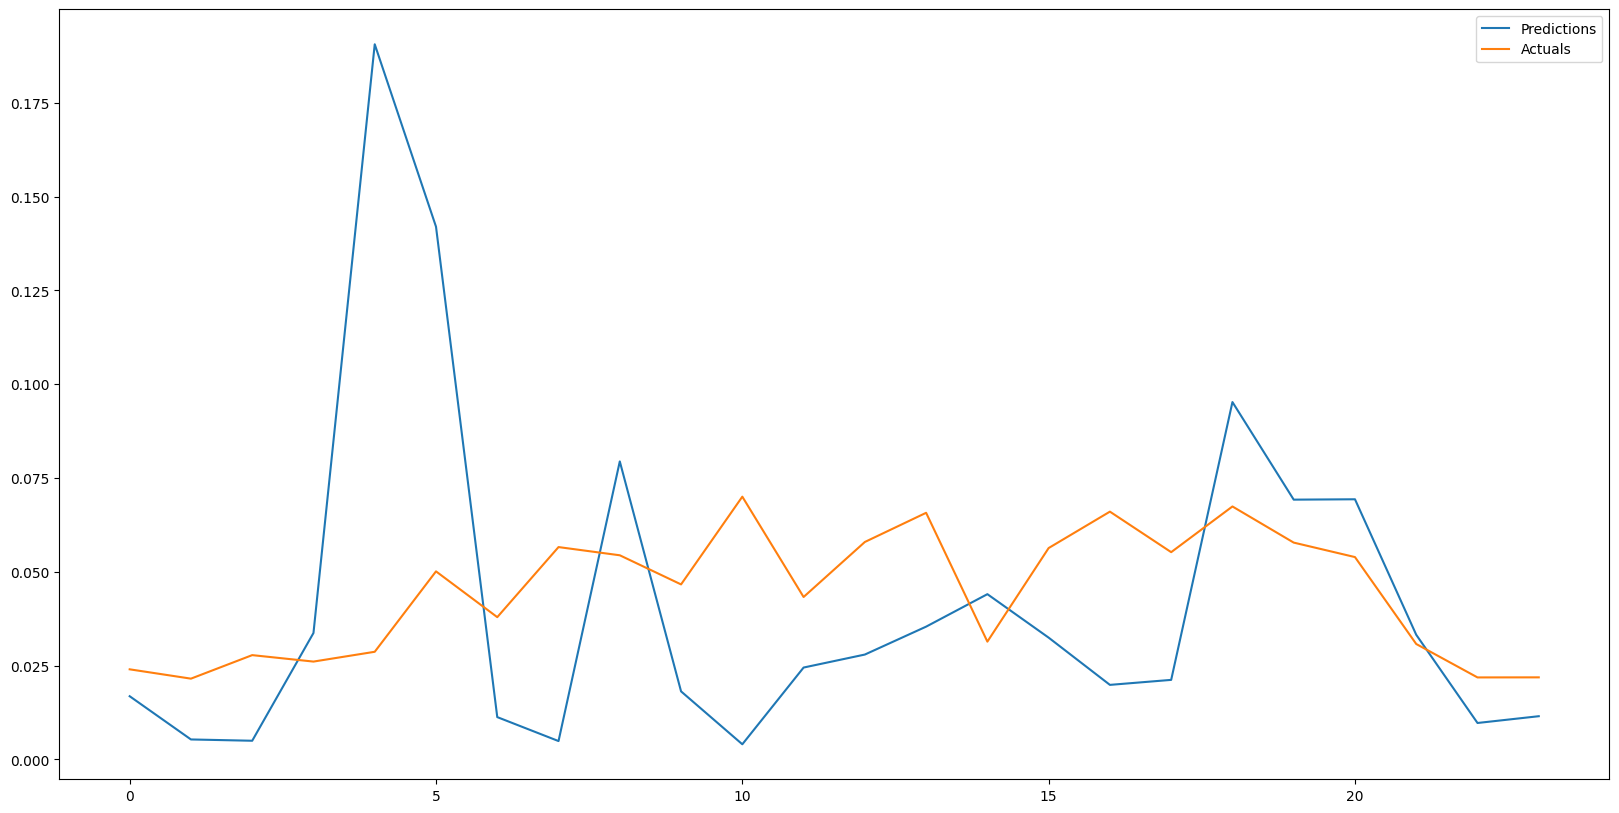

In [10]:
model = VAE(input_dim=24, hidden_dim = 500, z_dim = 40)

cbs = [EarlyStopping(monitor='val_loss', patience=30, mode='min')]
trainer = pl.Trainer(max_epochs=50, logger = wandb_logger, gpus=1 if torch.cuda.is_available() else 0, callbacks=cbs)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [70]:
trainer.test(model, test_dataloader)
torch.cuda.empty_cache()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            8.778602600097656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
